In [20]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [21]:
dataset = pd.read_csv("../data/assignment_preprocessed.csv")

### Creating a new subset
First we need to create a new subset based on our dataset using the columns of interest. In this case : 

```
columns_of_interest = ['ad_type', 'ranking_score', 'price_per_sqm', 'sq_meters', 'geography_name', 'subtype']
```

Then we need to create a new column.
1. **Weighted ranking** 
```
ad_type_weight: 'simple' = 1, 'up' = 2, 'premium' = 3, 'star' = 4
weighted_ranking = ranking_score * ad_type_weight
```

* ad_type: to calculate percentage of high-ranked and low-ranked listings
* ranking_score: to calculate the ranking score distribution
* price_per_sqm: to calculate the average price per square meter
* sq_meters: to calculate the total area (in square meters) of listings in each area
* geography_name: to group the data by area
* subtype: to group the data by property type and calculate the metrics separately for each property type
* weighted_ranking


One information that would also give us some completitiveness information would be **time_on_market** to calculate the median time on market. We cannot calculate the `time_on_market` with the information given since we can't assume that the year the listing has been constructed is the year the listing has been made.

In [3]:
columns_of_interest = ['ad_type', 'ranking_score', 'price_per_sqm', 'sq_meters', 'geography_name', 'subtype']
subset = dataset[columns_of_interest].copy()

In [4]:
subset['weighted_ranking'] = subset['ranking_score'] * subset['ad_type'].replace(['simple', 'up', 'premium', 'star'], [1, 2, 3, 4], inplace=False)

### Helping Functions

In [5]:
def pie_chart_for_each_category(subset, to_groupby):
    names = subset[to_groupby].unique()
    row = int(len(names)/2) if len(names)%2 == 0 else int(len(names)/2) + 1
    colors = plt.cm.tab20(np.linspace(0, 1, len(subset['ad_type'].unique())))
    # ad_type_color_dict = dict(zip(subset['ad_type'].unique(), colors)) # create a dictionary to map each ad type to its color
    fig, axes = plt.subplots(nrows=row, ncols=2, figsize=(8, len(names)*2))
    axe = axes.ravel()
    suptitle = "Each ad_type percentage in " + to_groupby
    fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    for i, name in enumerate(names):
        subset_grouped = subset[subset[to_groupby] == name]
        ax = subset_grouped['ad_type'].value_counts().plot(kind='pie', ax=axe[i], autopct='%1.1f%%', colors=colors)
        ax.get_yaxis().set_visible(False)
        # Set the title for the current subplot
        ax.set_title(name)
        ax.legend(loc='upper right')
    # handles = []
    # labels = []
    # for i, name in enumerate(names):
    #     subset_grouped = subset[subset[to_groupby] == name]
    #     values, _, _ = axe[i].pie(subset_grouped['ad_type'].value_counts(), 
    #                               colors=[ad_type_color_dict[x] for x in subset_grouped['ad_type'].unique()],
    #                               autopct='%1.1f%%')
    #     axe[i].set_title(name)
    #     axe[i].get_yaxis().set_visible(False)
    #     for j, label in enumerate(subset_grouped['ad_type'].unique()):
    #         handles.append(values[j])
    #         labels.append(label)
    # # fig.legend(handles, labels, loc='upper right')

    # fig.legend(subset['ad_type'].unique(), loc='upper right')


In [6]:
def get_highest_per_category(subset, to_groupby, find_stats_of):
    counts = subset.groupby([to_groupby, find_stats_of], group_keys=True).size()
    percentages = counts.groupby(level=0, group_keys=False).apply(lambda x: round(x / x.sum() * 100, 2))
    highest_per_cat = dict()
    for name in subset[find_stats_of].unique():
        per = percentages[percentages.index.get_level_values(find_stats_of) == name]
        highest_per_cat[name] = {to_groupby: per.idxmax()[0], 'percentage': per.max()}
    display(pd.DataFrame.from_dict(highest_per_cat, orient='index'))

## Competitiveness


#### Price-based
**Average price per square meter**
> This metric can be calculated by grouping the dataset by `geography_name` and taking the mean of the `price_per_sqm` column. 

A higher average `price_per_sqm` would indicate higher competition in the area.

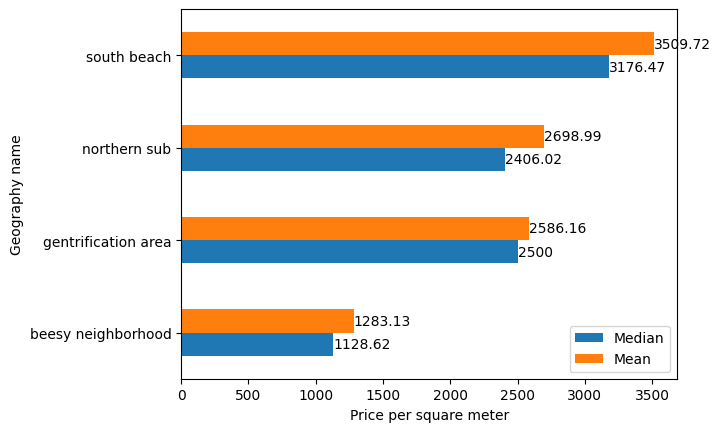

In [7]:
ax = pd.DataFrame({'median':subset.groupby('geography_name')['price_per_sqm'].median().sort_values(), 'mean':subset.groupby('geography_name')['price_per_sqm'].mean().sort_values()}).plot(kind='barh')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xlabel('Price per square meter')
plt.ylabel('Geography name')
plt.legend(['Median', 'Mean'])
plt.show()


**Price variation by square meter**
> This metric can be calculated by grouping the dataset by `geography_name` and taking the standard deviation of the `price_per_sqm` column. 

A higher standard deviation would indicate higher competition in the area.

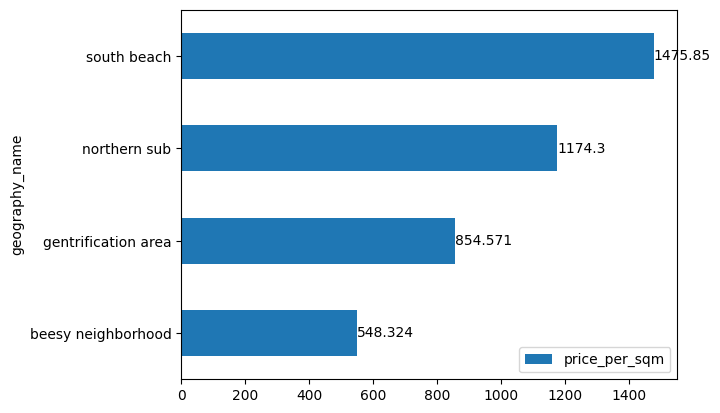

In [8]:
result = subset.groupby('geography_name', as_index=False)['price_per_sqm'].std()

ax = result.plot.barh(x='geography_name', y='price_per_sqm')
ax.bar_label(ax.containers[0])
plt.show()


**Price per square meter compared to median for all areas**
> This metric can be calculated by dividing the price_per_sqm for each area by the overall median price_per_sqm for all areas.

A ratio greater than 1 would indicate higher competition in the area, while a ratio less than 1 would indicate lower competition.

In [9]:
overall_median = subset['price_per_sqm'].median()

# Calculate the price_per_sqm ratio for each area
subset['price_per_sqm_ratio'] = subset['price_per_sqm'] / overall_median
subset['price_per_sqm_ratio'] = subset.groupby('geography_name', group_keys=False)['price_per_sqm'].apply(lambda x: x / overall_median)

# Set the threshold
threshold = 1

# Count the number of price_per_sqm_ratio per area that are greater than the threshold
area_ratio_count_higher = subset.groupby('geography_name')['price_per_sqm_ratio'].apply(lambda x: np.sum(x > threshold))
percentage = round(area_ratio_count_higher / subset.groupby('geography_name').size() * 100, 2) 
print('The geography name with the highest number of listings with ratio greater than the threshold is\033[1m', percentage.idxmax(),'\033[0m with', percentage.max(), '%.')

The geography name with the highest number of listings with ratio greater than the threshold is south beach  with 74.43 %.


#### Ranking-score based

**Ranking score distribution**
> This metric can be calculated by grouping the dataset by `geography_name` and examining the distribution of `ranking_scores` for each area. 

A wider distribution of `ranking_scores` would indicate higher competition in the area.

In [10]:
print('Ranking score per geography_name')
display(subset.groupby('geography_name', as_index=False).agg({'ranking_score':['count', 'min', 'max', 'mean', 'median', 'std']}))

Ranking score per geography_name


geography_name ranking_score                                   \
                               count   min    max        mean  median   
0   beesy neighborhood          1598  33.5  170.5  113.744869  117.70   
1  gentrification area           616  29.3  177.7  119.857792  123.85   
2         northern sub          3505  27.8  181.9  116.264936  119.50   
3          south beach          4141  23.5  177.0  115.943589  120.70   

              
         std  
0  32.085281  
1  30.091367  
2  30.130535  
3  32.649372

A wider distribution can be identified by the shape of the density plot, where a wider distribution typically has a lower and flatter curve than a narrow distribution, which has a taller and narrower curve. In this case gentrification are has a wider distribution which can indicate a higher competition in that area.

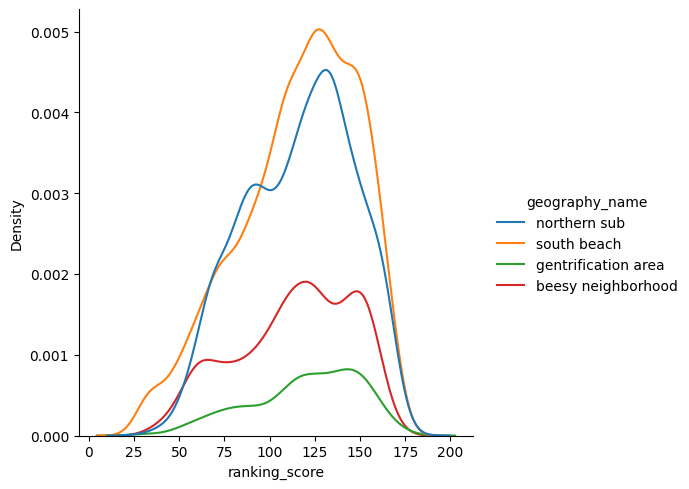

In [11]:
sns.displot(data=subset, x="ranking_score", hue="geography_name", kind="kde")

In [12]:
print('Weighted Ranking score per geography_name')
display(subset.groupby('geography_name', as_index=False).agg({'weighted_ranking':['count', 'min', 'max', 'mean', 'median', 'std']}))

Weighted Ranking score per geography_name


geography_name weighted_ranking                                  \
                                  count   min    max        mean median   
0   beesy neighborhood             1598  33.5  678.8  124.947997  119.7   
1  gentrification area              616  29.3  700.0  141.991721  125.4   
2         northern sub             3505  27.8  680.0  135.720770  122.0   
3          south beach             4141  23.5  676.8  128.012968  122.6   

              
         std  
0  67.516785  
1  90.194934  
2  86.585046  
3  70.984831

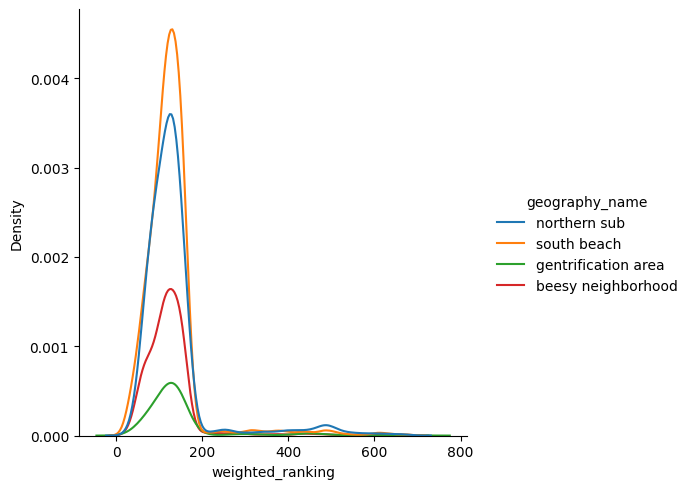

In [13]:
sns.displot(data=subset, x="weighted_ranking", hue="geography_name", kind="kde")

**Percentage of high-ranking listings per ad type**
> This metric can be calculated by grouping the dataset by `geography_name` and `ad_type` and counting the number of listings with a `ranking_scores` above a certain threshold as a percentage of the total number of listings in the area. 

A higher percentage of high-ranking listings would indicate higher competition in the area.


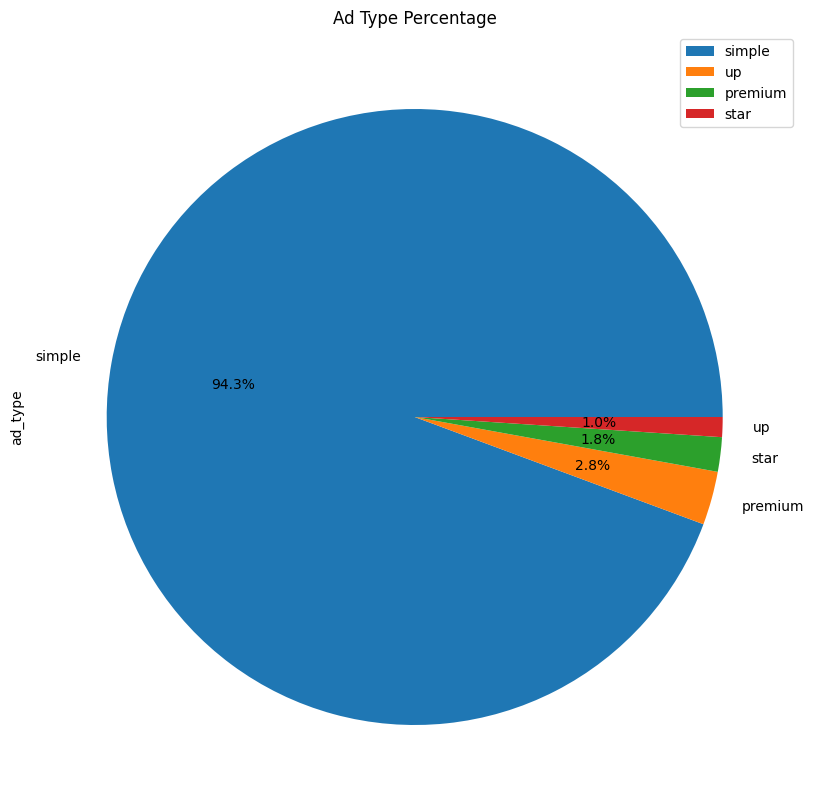

In [14]:
ax = subset['ad_type'].value_counts().plot.pie(figsize=(10, 10), y='MATH', autopct='%1.1f%%', legend=True)
plt.legend(labels =['simple', 'up', 'premium', 'star'])
plt.title('Ad Type Percentage')
plt.show()

In [15]:
get_highest_per_category(subset, 'geography_name', 'ad_type')

,geography_name,percentage
simple,south beach,95.41
up,gentrification area,2.11
premium,gentrification area,4.71
star,northern sub,2.40


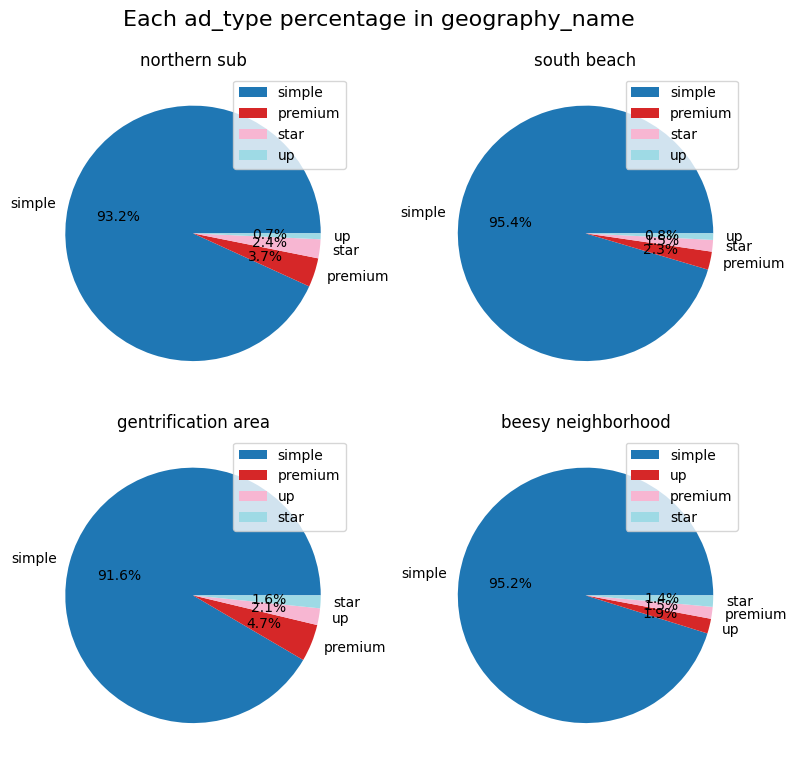

In [16]:
pie_chart_for_each_category(subset, 'geography_name')

In [17]:
# How many listings of each ad type per area have a higher weighted ranking score than a threshold

for ad_type in subset['ad_type'].unique():
    print("Ad Type:", ad_type)
    threshold = subset[subset['ad_type'] == ad_type]['weighted_ranking'].quantile(0.9)
    result = subset[subset['ad_type']==ad_type].assign(high_weighted_ranking_score=lambda x: x['weighted_ranking'] > threshold) \
                                      .groupby('geography_name')['high_weighted_ranking_score'] \
                                      .sum()
    display(result.to_frame())

Ad Type: simple


,high_weighted_ranking_score
geography_name,
beesy neighborhood,132
gentrification area,52
northern sub,322
south beach,417


Ad Type: up


,high_weighted_ranking_score
geography_name,
beesy neighborhood,2
gentrification area,5
northern sub,1
south beach,3


Ad Type: premium


,high_weighted_ranking_score
geography_name,
beesy neighborhood,1
gentrification area,3
northern sub,16
south beach,8


Ad Type: star


,high_weighted_ranking_score
geography_name,
beesy neighborhood,3
gentrification area,2
northern sub,7
south beach,6


In [18]:
thresholds = {ad_type: subset[subset['ad_type'] == ad_type]['weighted_ranking'].quantile(0.9) for ad_type in subset['ad_type'].unique()}
result = subset.assign(high_weighted_ranking_score=lambda x: x['weighted_ranking'] > thresholds[x['ad_type'].iloc[0]]) \
               .groupby(['geography_name', 'ad_type'])['high_weighted_ranking_score'] \
               .sum() \
               .reset_index() \
               .groupby('geography_name')['high_weighted_ranking_score'] \
               .sum()
ratio_high_wrs = round(result / subset.groupby('geography_name').size() * 100, 2)

display(ratio_high_wrs.to_frame())
print('The geography name with the highest percentage of ranking scores about the given threshold is\033[1m', ratio_high_wrs.idxmax(),'\033[0m with', ratio_high_wrs.max(), '%.')

,0
geography_name,
beesy neighborhood,13.08
gentrification area,16.88
northern sub,15.95
south beach,14.44


The geography name with the highest percentage of ranking scores about the given threshold is gentrification area  with 16.88 %.


In [19]:
threshold = subset['ranking_score'].quantile(0.9)
result = subset.assign(high_ranking_score=lambda x: x['ranking_score'] > threshold) \
               .groupby(['geography_name', 'ad_type'])['high_ranking_score'] \
               .sum() \
               .reset_index() \
               .groupby('geography_name')['high_ranking_score'] \
               .sum()
ratio_high_rs = round(result / subset.groupby('geography_name').size() * 100, 2)

display(ratio_high_rs.to_frame())
print('The geography name with the highest percentage of ranking scores about the given threshold is\033[1m', ratio_high_rs.idxmax(),'\033[0m with', ratio_high_rs.max(), '%.')

,0
geography_name,
beesy neighborhood,8.01
gentrification area,9.58
northern sub,10.41
south beach,10.41


The geography name with the highest percentage of ranking scores about the given threshold is northern sub  with 10.41 %.


#### Other metrics

**Median time on market**

> This metric can be calculated by grouping the dataset by `geography_name` and taking the median of the `time_on_market` column. 

A lower median `time_on_market` would indicate higher competition in the area.

Since we can't calculate the `time_on_market` we cannot use that metric. The implementation would be that:

```python
    median = subset.groupby('geography_name')['time_on_market'].median()
    print(median.idxmin(), median.min())
    mean = subset.groupby('geography_name')['time_on_market'].mean()
    print(mean.idxmin(), round(mean.min(), 2))

```

**Price per square meter relative to time on market**
> This metric can be calculated by dividing the `price_per_sqm` by the `time_on_market` for each listing, and then taking the average of these ratios for each area. 

A higher ratio would indicate higher competition in the area, as it suggests that listings are selling quickly despite high prices.

Again since we can't calculate the `time_on_market` we cannot use that metric. The implementation would be that:

```python
    subset['price_per_sqm_to_time_on_market'] = subset[subset['time_on_market'] != 0].apply(lambda row: row['price_per_sqm'] / row['time_on_market'], axis=1)
    avg_price_per_sqm_to_time_on_market = subset.groupby('geography_name')['price_per_sqm_to_time_on_market'].mean()
```